# Summary Table & Finding Codes EDA

## Postgres Connections and Functions

In [7]:
import sqlalchemy
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import yaml

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Read in config file
with open("../conf/local/db.yaml") as f:
    conf=yaml.safe_load(f)

In [9]:
# set up sqlalchemy engine
host = conf['host']
DB = conf['DB']
user = conf['user']
pw = conf['pw']

connection_string = "postgresql://{}:{}@{}/{}".format(user, pw, host, DB)
conn = sqlalchemy.create_engine(connection_string)

In [10]:
# Get Summary Datatable
query = """
select * 
from DM_Spain_VIEW_study_summary;
"""

sum_table = pd.read_sql(query, conn)
sum_table.head()

,row_id,studyidk,age,gender,patientweight,patientheight,findingcode,findingcodetext,conclusion,reasonforstudy,studylocation,modality,equipment
0,1,118640,77,M,77,162,"LV-0062, LV-0067, LV-0078, LV-0088, RV-0028, R...",Ventrículo izquierdo de dimensiones normales. ...,RS. Buena calidad. ....- VI de tamańo y FEVI n...,SVAo. BAV 2ş,,US,EPIQ7-1
1,2,115777,82,F,45,157,"LV-0063, LV-0069, LV-0078, LV-0086, LV-0087, L...",Cavidad del ventrículo izquierdo reducida. Com...,Estudio de buena calidad. Realizado en RS a 70...,Angina inestable,,US,ECOEPIQ2
2,3,49414,67,M,69,168,"LV-0077, MV-0108, AV-0087",La fracción de eyección del ventrículo izquier...,Seguimiento de P. con C. valvular e Isquemica....,Seguimiento de P. con C. valvular e Isquemica,,"SR, US",ECOIE33
3,4,79460,70,M,68,168,"LV-0078, LV-0145, MV-0056, MV-0099, MV-0108, T...",La función sistólica ventricular izquierda es ...,Seguimiento de P. con C. isquemica cronica (...,Seguimiento de P. con C. isquemica cronica +...,,"SR, US",AFFINITI_1
4,5,118806,72,M,63,167,"LV-0062, LV-0067, RV-0028, RV-0033, RV-0036, L...",Ventrículo izquierdo de dimensiones normales. ...,Estudio realizado en FA 80-90 . Mala ventana ...,,,"SR, US",AFFINITI_2


## Table Cleanup

In [11]:
sum_table_clean = sum_table.copy()

### Age

count    25064.000000
mean        64.289180
std         19.803252
min          0.000000
25%         55.000000
50%         69.000000
75%         79.000000
max        115.000000
Name: age, dtype: float64


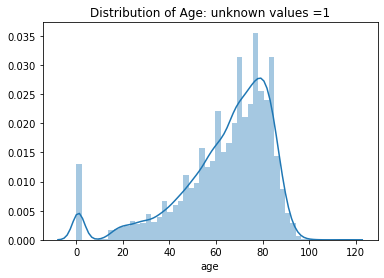

In [12]:
# Where value is blank, update value to '1'
sum_table_clean['age'] = sum_table_clean['age'].replace('',1)
sum_table_clean['age'] = sum_table_clean['age'].replace(np.nan, 1)
sum_table_clean['age'] = sum_table_clean['age'].astype(int)

# where age is more than 120, update value to '1'
sum_table_clean['age'] = sum_table_clean['age'].apply(lambda x: x if x < 120 else 1)
print(sum_table_clean['age'].describe())
#sum_table_clean['age'].hist()
sns.distplot(sum_table_clean['age'])
plt.title('Distribution of Age: unknown values =1')
plt.show()

### Weight

count    25064.000000
mean        65.157816
std         26.264251
min          0.080000
25%         59.000000
50%         70.000000
75%         80.000000
max        193.000000
Name: patientweight, dtype: float64


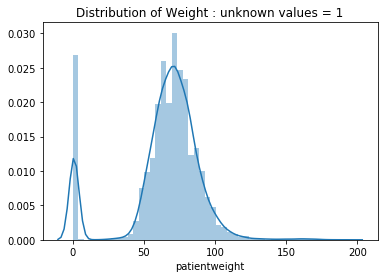

In [13]:
# Where value is blank, update value to '1'
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].replace('',1)
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].replace(np.nan, 1)
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].str.replace(',','.')
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].fillna(1)

#Change commas to decimal points
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].astype(float)

# where weigh is more than 440, update value to '1'
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].apply(lambda x: x if x < 440 else 1)
print(sum_table_clean['patientweight'].describe())
#sum_table_clean['patientweight'].hist()
sns.distplot(sum_table_clean['patientweight'])
plt.title('Distribution of Weight : unknown values = 1')
plt.show()

### Height

count    25064.000000
mean       146.605724
std         51.131713
min          1.000000
25%        155.000000
50%        162.000000
75%        170.000000
max        200.000000
Name: patientheight, dtype: float64


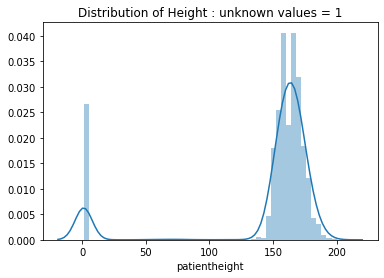

In [14]:
# Where value is blank, update value to '1'
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].replace('',1)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].replace(np.nan, 1)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].str.replace(',','.').astype(float)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].fillna(1)

#Change commas to decimal points
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].astype(float)

# where height is more than 250, update value to '1'
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].apply(lambda x: x if x < 250 else 1)
print(sum_table_clean['patientheight'].describe())
#sum_table_clean['patientheight'].hist()
sns.distplot(sum_table_clean['patientheight'])
plt.title('Distribution of Height : unknown values = 1')
plt.show()

## Create Features

### BMI

In [15]:
# Create BMI feature
#https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_1.html
# [weight (kg) / height (cm) / height (cm)] x 10,000
def calc_bmi(weight_kg, height_cm):
    return ((weight_kg/height_cm/height_cm)*10000)

In [16]:
# Create BMI Columns
sum_table_clean['BMI'] = sum_table_clean.apply(lambda x: calc_bmi(x.patientweight, x.patientheight), axis=1)

# where BMI is more than 45, update value to '1'
sum_table_clean['BMI'] = sum_table_clean['BMI'].apply(lambda x: x if x < 45 else 1)
# where BMI is less than 15, update value to '1'
sum_table_clean['BMI'] = sum_table_clean['BMI'].apply(lambda x: x if x > 15 else 1)

count    25064.000000
mean        23.771455
std          9.233790
min          1.000000
25%         22.405877
50%         25.677297
75%         28.906250
max         44.997166
Name: BMI, dtype: float64


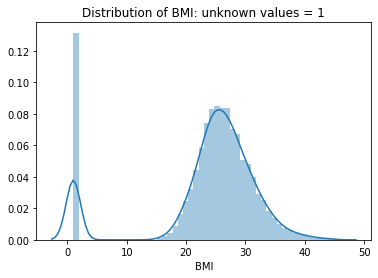

In [17]:
print(sum_table_clean['BMI'].describe())
#sum_table_clean['BMI'].hist()
sns.distplot(sum_table_clean['BMI'])
plt.title('Distribution of BMI: unknown values = 1')
plt.show()

### Finding Codes of Interest

In [18]:
#codes for each of the pathologies
pathologies_of_interest = {'LV-0068', 'LV-0144', 'LV-0069', 'LV-0070', 'LV-0065', 'LV-0062'
                    ,'LV-0061', 'LV-0080','LV-0077','LV-0078'
                    , 'LV-0061', 'LA-0016', 'LA-0013', 'SU-0032'}

# Pathology dictonary
pathdict = {"LV-0062": "HC_F"
            ,"SU-0032": "Norm"
            ,"LV-0078": "RLVEF_F"
            ,"LV-0077": "RLVEF_F"
            ,"LV-0061": "RLVEF_F"
            ,"LV-0080": "RLVEF_T"
            ,"LV-0068": "HC_T"
            ,"LA-0016": "DLA_T"
            ,"LV-0065": "HC_F"
            ,"LV-0144": "HC_T"
            ,"LV-0070": "HC_C"
            ,"LA-0013": "DLA_F"
            ,"LV-0069": "HC_C"
           }

# Pathology codes
HC_T_codes = {'LV-0144', 'LV-0068'}
HC_F_codes = {'LV-0062', 'LV-0065', 'LV-0061'}
HC_C_codes = {'LV-0069', 'LV-0070'}

RLVEF_T_codes = {'LV-0080'}
RLVEF_F_codes = {'LV-0061', 'LV-0077', 'LV-0078'}

DLA_T_codes = {'LA-0016'}
DLA_F_codes = {'LA-0013'}

Norm_codes = {'SU-0032'}

In [19]:
def create_pathology_column(study_table, path_codes, path_name):
    #puts the code of interest in a new column
    study_table[path_name] = study_table.findingcode.apply(lambda x: intersection(x, path_codes)) 
    #replace the codes with 0 or 1 (NOTE: could return higher than 1 error?  needs to be handled)
    study_table[path_name] = study_table[path_name].apply(lambda x : len(x))
    
    #Convert the code from a list to a string
    #study_table[path_name] = study_table[path_name].apply(lambda x : ''.join(x))
    # replace the codes with the pathology names
    #study_table = study_table.replace({path_name: pathdict})
    return study_table

In [20]:
def intersection(lst1, lst2): 
#https://www.geeksforgeeks.org/python-intersection-of-multiple-lists/      
    return [item for item in lst1 if item in lst2] 

In [21]:
# turn the findingcode column into a list
sum_table_clean.findingcode = sum_table_clean.findingcode.apply(lambda x: x.split(","))

In [22]:
# adding pathology column
sum_table_clean = create_pathology_column(sum_table_clean, HC_T_codes, "HC_T")
sum_table_clean = create_pathology_column(sum_table_clean, HC_F_codes, "HC_F")
sum_table_clean = create_pathology_column(sum_table_clean, HC_C_codes, "HC_C")
sum_table_clean = create_pathology_column(sum_table_clean, RLVEF_T_codes, "RLVEF_T")
sum_table_clean = create_pathology_column(sum_table_clean, RLVEF_F_codes, "RLVEF_F")
sum_table_clean = create_pathology_column(sum_table_clean, DLA_T_codes, "DLA_T")
sum_table_clean = create_pathology_column(sum_table_clean, DLA_F_codes, "DLA_F")
sum_table_clean = create_pathology_column(sum_table_clean, Norm_codes, "Norm")

In [23]:
sum_table_clean.head()

,row_id,studyidk,age,gender,patientweight,patientheight,findingcode,findingcodetext,conclusion,reasonforstudy,...,equipment,BMI,HC_T,HC_F,HC_C,RLVEF_T,RLVEF_F,DLA_T,DLA_F,Norm
0,1,118640,77,M,77.0,162.0,"[LV-0062, LV-0067, LV-0078, LV-0088, RV-00...",Ventrículo izquierdo de dimensiones normales. ...,RS. Buena calidad. ....- VI de tamańo y FEVI n...,SVAo. BAV 2ş,...,EPIQ7-1,29.340040,0,1,0,0,0,0,0,0
1,2,115777,82,F,45.0,157.0,"[LV-0063, LV-0069, LV-0078, LV-0086, LV-00...",Cavidad del ventrículo izquierdo reducida. Com...,Estudio de buena calidad. Realizado en RS a 70...,Angina inestable,...,ECOEPIQ2,18.256319,0,0,0,0,0,0,0,0
2,3,49414,67,M,69.0,168.0,"[LV-0077, MV-0108, AV-0087]",La fracción de eyección del ventrículo izquier...,Seguimiento de P. con C. valvular e Isquemica....,Seguimiento de P. con C. valvular e Isquemica,...,ECOIE33,24.447279,0,0,0,0,1,0,0,0
3,4,79460,70,M,68.0,168.0,"[LV-0078, LV-0145, MV-0056, MV-0099, MV-01...",La función sistólica ventricular izquierda es ...,Seguimiento de P. con C. isquemica cronica (...,Seguimiento de P. con C. isquemica cronica +...,...,AFFINITI_1,24.092971,0,0,0,0,1,0,0,0
4,5,118806,72,M,63.0,167.0,"[LV-0062, LV-0067, RV-0028, RV-0033, RV-00...",Ventrículo izquierdo de dimensiones normales. ...,Estudio realizado en FA 80-90 . Mala ventana ...,,...,AFFINITI_2,22.589551,0,1,0,0,0,0,0,0


## Histograms: Pathologies by Demographics

In [24]:
sum_table_clean['HC_T'].sum()

100

In [25]:
# Create a table of relevant findingcodes/pathologies

columns = ["Findingcode diagnosing disease",
           "Findingcode compatible with disease", 
           "Findingcode normal for this pathology"]
rows = ["Hypertrophic Cardiomyopathy",
        "Reduced Left Ventricle Ejection Fraction",
       "Dilated Left Atria",
       "Normal study"]
data=[[sum_table_clean['HC_T'].sum(), sum_table_clean['HC_C'].sum(), sum_table_clean['HC_F'].sum()],
     [sum_table_clean['RLVEF_T'].sum(), " ", sum_table_clean['RLVEF_F'].sum()],
     [sum_table_clean['DLA_T'].sum(), " ", sum_table_clean['DLA_F'].sum()],
     [sum_table_clean['Norm'].sum(), " ", " "]]

ResultsTable = pd.DataFrame(index=rows, columns=columns, data=data)

ResultsTable


,Findingcode diagnosing disease,Findingcode compatible with disease,Findingcode normal for this pathology
Hypertrophic Cardiomyopathy,100,12,15447
Reduced Left Ventricle Ejection Fraction,415,,1741
Dilated Left Atria,68,,5
Normal study,1857,,


## Pathologies present by age, weight, height and BMI

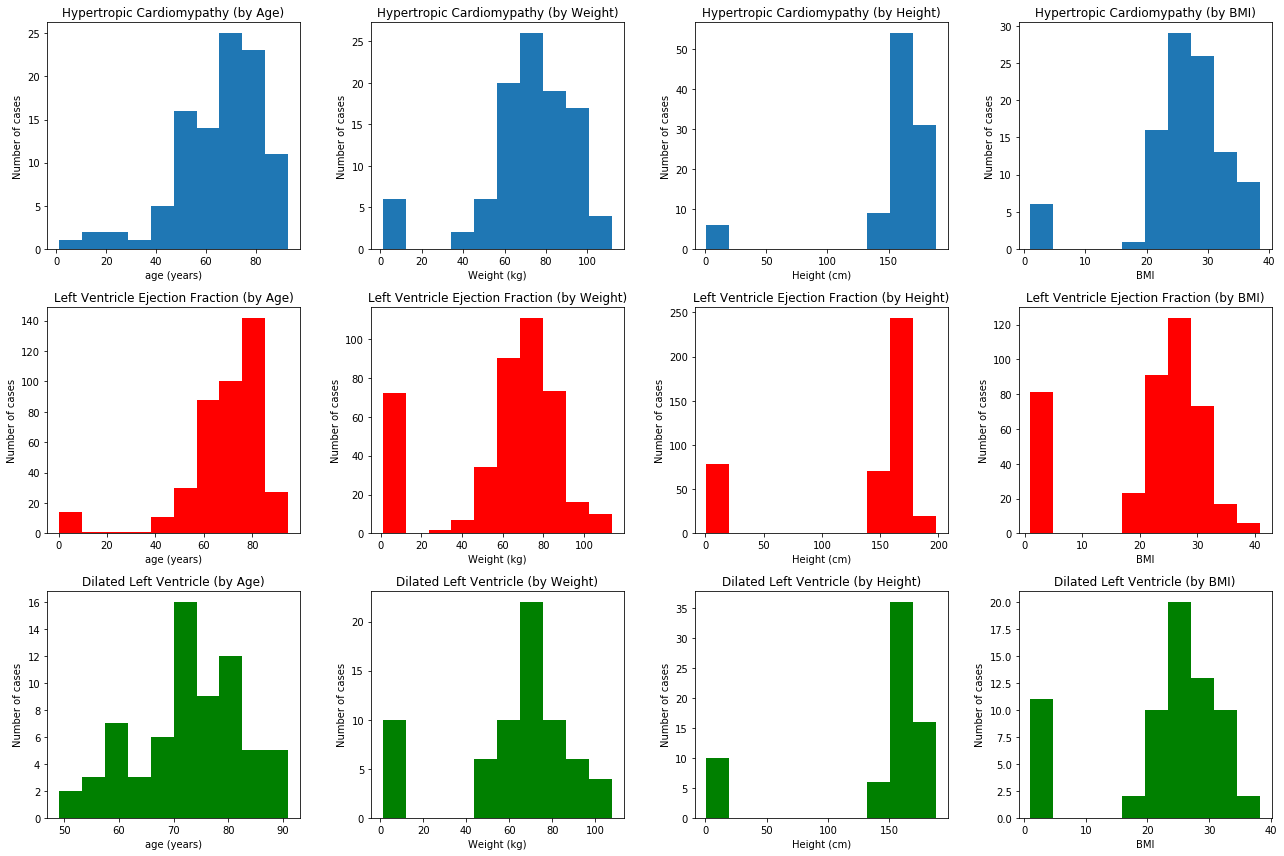

In [26]:
HC_T_Table = sum_table_clean[sum_table_clean['HC_T'] == 1]
RLVEF_T_Table = sum_table_clean[sum_table_clean['RLVEF_T'] == 1]
DLA_T_Table = sum_table_clean[sum_table_clean['DLA_T'] == 1]

# Age, weight, hieght, and BMI for HC_T
plt.figure(figsize=(18, 12))

plt.subplot(3, 4, 1)
HC_T_Table.age.hist()
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 5)
RLVEF_T_Table.age.hist(color='red')
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 9)
DLA_T_Table.age.hist(color='green')
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 2)
HC_T_Table.patientweight.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 6)
RLVEF_T_Table.patientweight.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 10)
DLA_T_Table.patientweight.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 3)
HC_T_Table.patientheight.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 7)
RLVEF_T_Table.patientheight.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 11)
DLA_T_Table.patientheight.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 4)
HC_T_Table.BMI.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 8)
RLVEF_T_Table.BMI.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 12)
DLA_T_Table.BMI.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.tight_layout()
plt.show()